In [20]:
from glob import glob
import os
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
COLORS=dict(zip(["burst", "utree", "centrifuge", "kraken", "bowtie2", 'burst-capitalist', 'burst-lca', 3, 4, 5], sns.color_palette("colorblind", 10)))
sns.palplot(sns.color_palette("colorblind", 10))

%matplotlib inline

In [2]:
# Load up RS2KO
protein2kos = defaultdict(list)
with open("../results/uds/rs2ko.txt") as inf:
    for line in inf:
        row = line.rstrip().split("\t")
        row[0] = row[0].split('.')[0]
        protein2kos[row[0]].extend(row[1].split())

In [77]:
def save_plot(fig, pltname, artists=()):
    fig.savefig(os.path.join("..", "figures", "uds_" + pltname + ".png"), dpi=300, bbox_extra_artists=artists, bbox_inches='tight')

In [3]:
# Load up GMG.to.KO
rs2kos = defaultdict(list)
with open("../results/uds/./GMG.microbe.to.KO.map.txt") as inf:
    for line in inf:
        row = line.rstrip().split("\t")
        row[0] = row[0].split('.')[0]
        rs2kos[row[0]].extend(row[1].split())

In [4]:
rep82_R1 = glob("../results/uds/*_R1_001.rep82.b6")
rep82_set = set(rep82_R1)
miniGMG_R1 = glob("../results/uds/*_R1_001.miniGMG_darth.b6")
processing_pairs = []
for file in miniGMG_R1:
    rep82_file = file.replace("miniGMG_darth", "rep82")
    if rep82_file in rep82_set:
        processing_pairs.append([file, rep82_file])

In [5]:
# Given a string, and start and end string, return the sandwiched string within the the original string
def find_between(s, first, last):
    try:
        start = s.index(first) + len(first)
        end = s.index(last, start)
        return s[start:end]
    except ValueError:
        return ""

In [6]:
for miniGMG, rep82 in processing_pairs:
    output_folder = rep82.replace(".rep82.b6", "")
    hit = 0
    missed = 0
    basename = os.path.basename(output_folder)
    counter = Counter()
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        !shogun assign_taxonomy -o {output_folder}/taxatable.{basename}.txt -i {rep82} -d ../data/references/rep82/ -a burst
        !shogun functional -i {output_folder}/taxatable.{basename}.txt -l strain -d ../data/references/rep82/ -o {output_folder}
        !shogun functional -i {output_folder}/taxatable.{basename}.txt -l species -d ../data/references/rep82/ -o {output_folder}
        !shogun functional -i {output_folder}/taxatable.{basename}.txt -l genus -d ../data/references/rep82/ -o {output_folder}
    with open(miniGMG) as inf:
        with open(output_folder + "/keggs.perline.txt", "w") as outf:
            with open(output_folder + "/rid.missed.txt", "w") as outf_m:
                for line in inf:
                    row = line.rstrip().split("\t")
                    kegg_id_found = False
                    if "protein_id" in row[1]:
                        proteins = find_between(row[1], "[protein_id=", "]").split(",")
                        proteins = [protein.split(".")[0] for protein in proteins]
                        for protein in proteins:
                            if protein in protein2kos:
                                counter.update(protein2kos[protein])
                                outf.write("%s\n" % " ".join(protein2kos[protein]))
                                kegg_id_found = True
                                hit += 1
                    if kegg_id_found == False:
                        refseq_id = find_between(row[1], 'lcl|', ' ')
                        refseq_id = refseq_id.split('.')[0]
                        if refseq_id in rs2kos:
                            counter.update(rs2kos[refseq_id])
                            outf.write('%s\n' % " ".join(rs2kos[refseq_id]))
                            kegg_id_found = True
                            hit += 1
                        else:
                            missed += 1
                            outf_m.write("%s\n" % protein)
    print("%s\t%d\t%d\t%.2f" % (miniGMG, hit, missed, float(hit)/(hit+missed)))
    with open(output_folder + "/keggs.output.txt", "w") as outf:
        for key, value in counter.items():
            outf.write("%s\t%s\n" % (key, value))

../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_1_S1_L005_R1_001.miniGMG_darth.b6	5908816	2203694	0.73
../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_1_S1_L007_R1_001.miniGMG_darth.b6	5879457	2216664	0.73
../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_6_S6_L001_R1_001.miniGMG_darth.b6	5203938	2061778	0.72
../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_8_S8_L008_R1_001.miniGMG_darth.b6	4886198	2039465	0.71
../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_5_S5_L008_R1_001.miniGMG_darth.b6	5430175	2164441	0.72
../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_8_S8_L007_R1_001.miniGMG_darth.b6	5679700	2339215	0.71
../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_5_S5_L005_R1_001.miniGMG_darth.b6	6244540	2439196	0.72
../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_3_S3_L008_R1_001.miniGMG_darth.b6	5112109	1964766	0.72
../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_2_S2_L006_R1_001.miniGMG_darth.b6	6068343	2392928	0.72
../results/uds/160729_K00180_0226_AH7WCCBBXX.LS_4_S4_L007_R1_001.miniGMG_

In [7]:
# Merge taxatables
def fetch_merged_keggtable(level):
    kegg_ids = defaultdict(int)
    files = glob("../results/uds/**/*.{}.kegg.txt".format(level))
    for file in files:
        with open(file) as inf:
            next(inf)
            for line in inf:
                row = line.rstrip().split("\t")
                kegg_ids[row[0]] += int(row[1])      
    return pd.Series(kegg_ids)

In [8]:
df_kegg = fetch_merged_keggtable("strain")
print(df_kegg.sum())
df_kegg.shape

147469337436


(7283,)

In [9]:
# Merge taxatables
def fetch_merged_minigmg():
    kegg_ids = defaultdict(int)
    files = glob("../results/uds/**/keggs.output.txt")
    for file in files:
        with open(file) as inf:
            for line in inf:
                row = line.rstrip().split("\t")
                kegg_ids[row[0]] += int(row[1])
    return pd.Series(kegg_ids)

In [10]:
df_minigmg = fetch_merged_minigmg()
df_minigmg

K00001    20855434
K00002       87882
K00003    14547747
K00004         101
K00005    30331422
K00007       19497
K00008      754902
K00009      986042
K00010        3166
K00012     7192862
K00013      845921
K00014      830344
K00016      272519
K00018        4094
K00020         424
K00021       17863
K00023           3
K00024      194824
K00027      255586
K00028         162
K00029      103977
K00030          59
K00031       68682
K00033       10708
K00034         368
K00036     1798771
K00040       75613
K00041     3016926
K00042       60796
K00045          46
            ...   
K20491       15368
K20492       21562
K20527          10
K20528           9
K20530          16
K20532           8
K20533          17
K20534        2611
K20541      110619
K20542       37103
K20543      181404
K20609       65922
K20708          45
K20742          37
K20814        2874
K20830         522
K20859          68
K20861       20976
K20862       28064
K20866       29238
K20881       32901
K20885      

In [11]:
mini_set = set(df_minigmg.index)
kegg_set = set(df_kegg.index)

In [12]:
print(len(mini_set.intersection(kegg_set)))

4619


In [14]:
print(len(mini_set))

4630


In [15]:
print(len(kegg_set))

7283


In [91]:
# Merge taxatables
def fetched_hitrates(fulldepth_series):
    fulldepth_set = set(fulldepth_series.index)
    kegg_dict = defaultdict(int)
    files = glob("../results/uds/**/keggs.perline.txt")
    i = 0
    for file in files:
        with open(file) as inf:
            for line in inf:
                line = line.rstrip()
                if not line == "":
                    i += 1
                    kegg_dict[line] += 1
                    if i % 1000 == 1:
                        series = pd.Series(kegg_dict)
                        kegg_set = set(kegg_dict.keys())
                        yield i, series.corr(fulldepth_series, method='spearman'), len(fulldepth_set.intersection(kegg_set))/float(len(fulldepth_set.union(kegg_set))), series.corr(fulldepth_series, method='pearson')

In [92]:
df_kegg_small = df_kegg[[_ in mini_set for _ in df_kegg.index]]

In [93]:
df_running = pd.DataFrame(fetched_hitrates(df_kegg_small), columns=["depth", "spearman", "jaccard", "pearson"])
df_running.head()

/export/scratch/miniconda3/envs/analysis_SHOGUN/lib/python3.5/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/export/scratch/miniconda3/envs/analysis_SHOGUN/lib/python3.5/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


,depth,spearman,jaccard,pearson
0,1,NaN,0.000216,NaN
1,1001,-0.045992,0.072960,-0.043131
2,2001,0.069930,0.141806,-0.015878
3,3001,0.086901,0.198961,-0.007556
4,4001,0.121641,0.247456,-0.001400


In [94]:
 df_running = df_running.fillna(0)

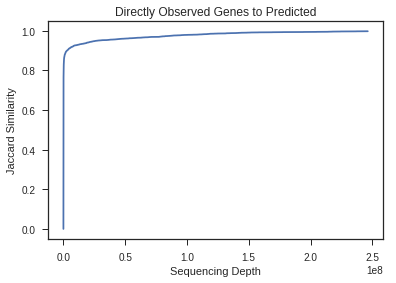

In [95]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: jaccard
# x-axis: sequencing depth
x = np.array([i*1001 for i in range(len(jaccards))])

fig, ax = plt.subplots()
plt.plot(df_running['depth'], df_running['jaccard'])

plt.title("Directly Observed Genes to Predicted")
plt.ylabel("Jaccard Similarity")
plt.xlabel("Sequencing Depth")
save_plot(fig, 'jaccard')

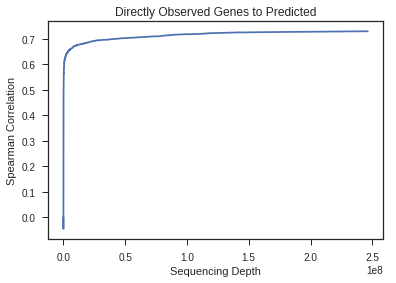

In [96]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: jaccard
# x-axis: sequencing depth

fig, ax = plt.subplots()
plt.plot(df_running['depth'], df_running['spearman'])

plt.title("Directly Observed Genes to Predicted")
plt.ylabel("Spearman Correlation")
plt.xlabel("Sequencing Depth")
save_plot(fig, 'spearman')

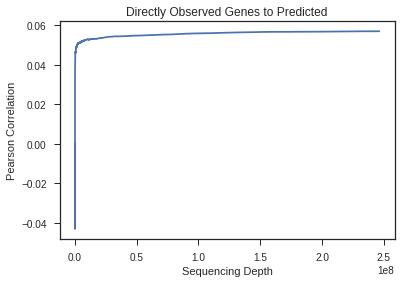

In [97]:
# We are interested in the speed up and efficiency of each of the aligners
# y-axis: jaccard
# x-axis: sequencing depth

fig, ax = plt.subplots()
plt.plot(df_running['depth'], df_running['pearson'])

plt.title("Directly Observed Genes to Predicted")
plt.ylabel("Pearson Correlation")
plt.xlabel("Sequencing Depth")
save_plot(fig, 'pearson')

In [61]:
df_kegg.corr(df_minigmg, method="spearman")

0.72970319250916571

In [63]:
df_kegg.index

Index(['K00001', 'K00002', 'K00003', 'K00004', 'K00005', 'K00007', 'K00008',
       'K00009', 'K00010', 'K00012',
       ...
       'K21019', 'K21020', 'K21021', 'K21022', 'K21023', 'K21024', 'K21025',
       'K21028', 'K21029', 'K21030'],
      dtype='object', length=7283)